In [1]:
from os import listdir
from os.path import isfile, join
import os
from glob import glob

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor, Resize
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import matplotlib.pyplot as plt

In [2]:
dog_train_path = 'data/dogImages/train'
dog_test_path = 'data/dogImages/test'
human_path = 'data/lfw/'

In [3]:
dog_train_files = [y for x in os.walk(dog_train_path) for y in glob(os.path.join(x[0], '*.jpg'))]
dog_test_files = [y for x in os.walk(dog_test_path) for y in glob(os.path.join(x[0], '*.jpg'))]
human_files = [y for x in os.walk(human_path) for y in glob(os.path.join(x[0], '*.jpg'))]

In [4]:
len(dog_train_files), len(dog_test_files), len(human_files)

(6680, 836, 13233)

In [5]:
dog_files = dog_train_files + dog_test_files

# since we have more human pictures than dog pictures
human_files_index = np.random.choice(np.arange(len(human_files)),
                                     size=len(dog_files), replace=False)
human_dset = [human_files[i] for i in human_files_index]

dog_dset = [(f, 0) for f in dog_files]
human_dset = [(f, 1) for f in human_dset]

In [6]:
assert len(human_dset) == len(dog_dset)

In [7]:
from random import shuffle

factor = 0.75

dset = dog_dset + human_dset
shuffle(dset)

dset_train_index = np.random.choice(np.arange(len(dset)),
                                    size=int(factor * len(dset)), replace=False)
dset_test_index = list(set(np.arange(len(dset))) - set(dset_train_index))

dset_train = [dset[i] for i in dset_train_index]
dset_test = [dset[i] for i in dset_test_index]

In [8]:
len(dset_train_index), len(dset_test_index)

(11274, 3758)

In [9]:
len([_[1] for _ in dset_train])

11274

In [10]:
len(list(filter(lambda x: x[1] == 0, dset_train)))/len(list(filter(lambda x: x[1] == 1, dset_train)))

1.0103423680456491

In [11]:
len(list(filter(lambda x: x[1] == 0, dset_test)))/len(list(filter(lambda x: x[1] == 1, dset_test)))

0.9696016771488469

In [12]:
class dataLoader:
    def __init__(self, dset, batch_size):
        self.dset = dset
        self.batch_size = batch_size
        self.pointer = 0
        
    def __len__(self):
        return len(self.dset) // self.batch_size
    
    def __iter__(self):
        return self
    
    def _image_to_tensor(self, path):
        return ToTensor()(Resize((64, 64,))(ImageFile.Image.open(path)))
    
    def __next__(self):
        while self.pointer < len(self):
            dl = self.dset[self.pointer * self.batch_size: (self.pointer + 1) * self.batch_size]
            x_paths = [f[0] for f in dl]
            dl_ys = [f[1] for f in dl]
            dl_xs = torch.stack([self._image_to_tensor(path) for path in x_paths], dim=0)
            self.pointer += 1
            return dl_xs.to(torch.float), torch.tensor(dl_ys).to(torch.long)
            
        self.pointer = 0
        raise StopIteration

In [13]:
class Net(nn.Module):
    
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 3)
        self.conv2 = nn.Conv2d(8, 16, 3)
         
        self.bn1 = nn.BatchNorm2d(8)
        self.bn2 = nn.BatchNorm2d(16)
         
        self.pool = nn.MaxPool2d(2)
        self.drop = nn.Dropout(0.2)
        
        self.fc = nn.Linear(3136, 2)
        
    def forward(self, x):
        x = F.relu(self.pool(self.bn1(self.conv1(x))))
        x = F.relu(self.pool(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [14]:
#  A bit better organized training routines

def optim_step(model, xs, ys, crit, optimizer):
    '''performs backprop and returns loss and accuracy'''
    optimizer.zero_grad()
    y_hat = model(xs)
    loss = crit(y_hat, ys)
    loss.backward()
    optimizer.step()
    return loss.item(), (ys == y_hat.max(dim=1)[1]).to(torch.float).mean()

epoch_info = {'new_epoch': False}
def print_train_msg(epoch, epochs,
                    running_loss, running_accuracy,
                    test_loss, test_accuracy, print_every, quiet_mode):

    print_msg = (f'\rEpoch: {epoch+1}/{epochs} ' +
                 f'Training loss: {running_loss/print_every:.3f} ' + 
                 f'Train Acc.: {running_accuracy/print_every:.3f} ' + 
                 f'Test loss: {test_loss:.3f} ' + 
                 f'Test Acc.: {test_accuracy:.3f}')
    if not quiet_mode:
        if epoch_info['new_epoch']:
            print('\n'+print_msg, end='')
            epoch_info['new_epoch'] = False
        else:
            print(print_msg, end='')

        

def train(model, device, trainloader, testloader, epochs, crit, optim, **kwargs):

    step = 0
    # kwargs
    quiet_mode = kwargs.pop('quiet_mode', False)
    print_every = kwargs.pop('print_every', 100)
    early_stop = kwargs.pop('early_stop', False)
    if kwargs:
        print('Unknow kwargs', kwargs)
        raise
    
    assert len(trainloader) >= print_every, f'{len(trainloader), {print_every}}'
    
#     return quiet_mode, print_every, early_stop,

    running_loss, running_acc = 0.0, 0.0
    model.to(device)
    for e in range(epochs):
        epoch_info['new_epoch'] = True
        model.train()
        for xs, ys in trainloader:
            xs, ys = xs.to(device), ys.to(device)
            step += 1
            loss, train_acc = optim_step(model, xs, ys, crit, optim)
            running_acc += train_acc
            running_loss += loss
            if step % print_every == print_every - 1:
                model.eval()
                with torch.no_grad():
                    test_loss, test_accuracy = validation(model, device, testloader, crit)
                print_train_msg(e, epochs, 
                                running_loss, running_acc,
                                test_loss, test_accuracy, 
                                print_every, quiet_mode)
                running_loss, running_acc = 0., 0.
                model.train()
                   
                    
        if early_stop:  # we want to check for early stop at the end of each epoch
            early_stop(test_loss, model)        
            if early_stop.early_stop:
                print('\nearly stopping', end='')
                break
    print('\nFinished training')                

def validation(model, device, testloader, crit):
    accuracy = 0
    test_loss = 0
    model.to(device)
    
    for xs, ys in testloader:
        xs, ys = xs.to(device), ys.to(device)
        ys_hat = model(xs)
        test_loss += crit(ys_hat, ys).item()
        # Class with highest probability is our predicted class, compare with true label
        equality = (ys.data == ys_hat.max(1)[1])
        # Accuracy is number of correct predictions divided by all predictions, just take the mean
        accuracy += equality.to(torch.float).mean()

    return test_loss / len(testloader), accuracy / len(testloader)

In [15]:
dl_train = dataLoader(dset_train, 16)
dl_test = dataLoader(dset_test, 16)
net = Net()

In [16]:
xs, ys = next(dl_test)

In [17]:
print_red = lambda x: f"\x1b[31m\"{x}\"\x1b[0m"
print_green = lambda x: f"\x1b[32m\"{x}\"\x1b[0m"
get_category = lambda x: "human" if x else "dog"

"dog""human""human""dog"
"dog""dog""dog""dog"
"dog""dog""dog""dog"
"dog""dog""dog""dog"


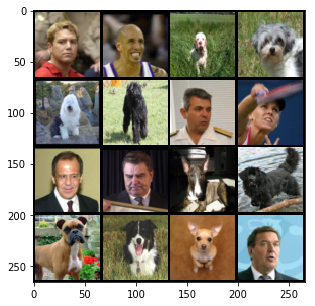

In [18]:
cat_names = [print_green(get_category(yhat)) if y ==yhat else print_red(get_category(yhat)) for \
 yhat, y in zip(net(xs).max(dim=1)[1], ys)]

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(torchvision.utils.make_grid(xs, 4).numpy().transpose(1, 2, 0))
for i in range(4):
    for j in range(4):
        print(cat_names[i*4 + j], end='' if j!=3 else None)

In [19]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
train(net, device, dl_train, dl_test, 3, 
      nn.CrossEntropyLoss(), torch.optim.SGD(net.parameters(), lr=0.001))


Epoch: 1/3 Training loss: 0.148 Train Acc.: 0.965 Test loss: 0.159 Test Acc.: 0.956
Epoch: 2/3 Training loss: 0.090 Train Acc.: 0.981 Test loss: 0.104 Test Acc.: 0.970
Epoch: 3/3 Training loss: 0.066 Train Acc.: 0.984 Test loss: 0.082 Test Acc.: 0.977
Finished training


"human""human""dog""dog"
"dog""dog""human""human"
"human""human""dog""dog"
"dog""dog""dog""human"


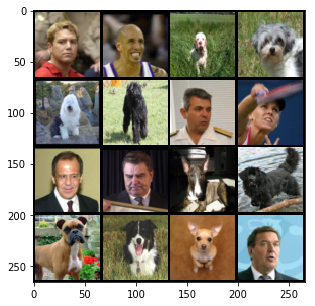

In [21]:
cat_names = [print_green(get_category(yhat)) if y ==yhat else print_red(get_category(yhat)) for \
 yhat, y in zip(net(xs).max(dim=1)[1], ys)]

fig, ax = plt.subplots(figsize=(5,5))
ax.imshow(torchvision.utils.make_grid(xs, 4).numpy().transpose(1, 2, 0))
for i in range(4):
    for j in range(4):
        print(cat_names[i*4 + j], end='' if j!=3 else None)